#Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(938, 473, 3)


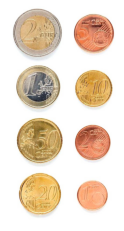

In [2]:
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

(0.0, 256.0)

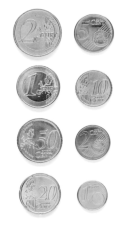

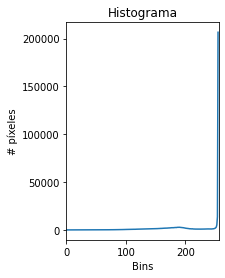

In [3]:
#Convierte a gris y muestra
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

Cuenta elementos tras umbralizar

Text(0.5, 1.0, 'OTSU invertida')

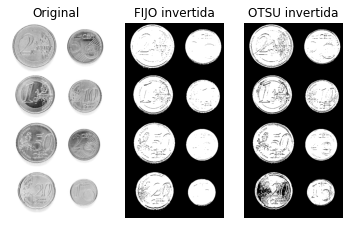

In [4]:
#Dos umbralizados. Te invito a probar con parámetros, aplicar filtro previo, etc.
umbral = 220
#Umbralización binaria invertida, objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Otsu
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13178.5 474.1736603975296 ((366.5, 815.5), (129.0, 131.0), 90.0) 366.5586853027344 814.9164428710938 66.21730041503906 ((366.5960388183594, 814.883544921875), (128.27664184570312, 131.4044189453125), 83.55007934570312)
25210.5 691.7960250377655 ((141.0, 809.0), (180.0, 180.0), 90.0) 141.97837829589844 810.4954833984375 93.07911682128906 ((141.660888671875, 808.5435180664062), (179.38943481445312, 179.82275390625), 68.5789794921875)
13.5 50.041630148887634 ((114.23530578613281, 672.5588989257812), (21.585670471191406, 2.425356149673462), 14.03624439239502) 114.5 671.5 10.79361629486084 ((114.66790771484375, 672.45654296875), (3.220008134841919, 19.657840728759766), 106.13774108886719)
18004.5 503.8305147886276 ((368.0, 587.0), (150.0, 152.0), 90.0) 368.23974609375 586.9910278320312 76.46900177001953 ((368.3546447753906, 587.0238037109375), (150.96194458007812, 151.9539337158203), 97.88601684570312)
29660.0 693.8965287208557 ((139.93075561523438, 578.7538452148438), (196.1978759765625, 1

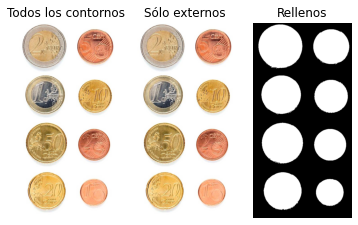

In [6]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con la figura en blanco y el fondo negro
#La imagen de entrada debe ser de un canal y 8 bits eccepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales

#Todos los contornos, externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de proximación del contorno
    )
#Sólo contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada todos los contornos en verde
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

# Dibuja sobre la imagen de entrada sólo contornos externos
cv2.drawContours(img_rgb, contornos2, -1, (0,0,255), 3)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

#Dibuja contornos externos en imagen vacía
#Muestra información
#Imagen vacía
img_cont = np.zeros(img_rgb.shape)
for c in contornos2:
    #Área
    area = cv2.contourArea(c)

    #Dimensión mínima (útil en ocasiones)
    if area > 10:
        #Perímetro
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que lo contiene
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos interesará mostrar estos valores
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')
plt.show()


TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas.

Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


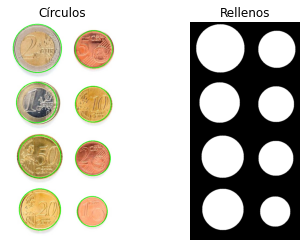

In [29]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, #Umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen.




Microplásticos

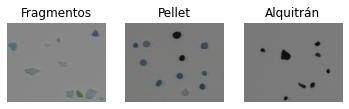

In [3]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán efectivamenet no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')
plt.show()

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa con las imágenes completas la matriz de confusión.